# traer data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-03-16 11:59:23.779240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 11:59:23.779285: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!pwd

/home/lucaspancotto/code/JoacoSoulez/mental_health_first_aid_evaluation/MHFA/notebooks/neural networks


In [3]:
twitter_reddit = pd.read_csv('../../../data/twitter_reddit_text.csv')
twitter_reddit.head()
twitter_reddit['text'] = twitter_reddit.clean_text
twitter_reddit.drop(columns=['clean_text','Unnamed: 0'] , inplace=True)
twitter_reddit = twitter_reddit[['text' , 'label']]

In [4]:
twitter_reddit.head()

,text,label
0,lay bed hour point back pain get work minut cl...,1
1,dlitedaili dont play wouldnt want anyth world,0
2,rewebcoach hey handsom time get day go,0
3,get readi tenni maryyi,0
4,hear song band almost never play favourit radi...,0


In [5]:
transcriptions = pd.read_csv('../../../transcriptions/targets/transcriptions_targets_lemmatized.csv')
transcriptions.head()
transcriptions['text'] = transcriptions.lemmatized_text
transcriptions['label'] = transcriptions.PHQ8_Binary
transcriptions = transcriptions.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0','clean_text',
       'lemmatized_text', 'PHQ8_Binary'])

In [6]:
transcriptions.head()

,text,label
0,fine angeles california family friend mixture ...,0.0
1,moscow family moved moved eventually college l...,0.0
2,connecticut actor moved san francisco moved at...,0.0
3,originally angeles weather family moved lot cu...,1.0
4,angeles lot thing love beach love love sunny t...,1.0


In [7]:
reddit_uncored = pd.read_csv('../../../uncored_data/reddit_uncored2.csv')
transcriptions_uncored = pd.read_csv('../../../uncored_data/transcription_uncored.csv')

transcriptions_uncored['text'] = transcriptions_uncored.uncored
transcriptions_uncored['label'] = transcriptions_uncored.PHQ8_Binary
transcriptions_uncored.drop(columns=  ['Unnamed: 0' , 'uncored','Unnamed: 0.1','PHQ8_Binary'] , inplace=True)

In [8]:


reddit_uncored['text'] = reddit_uncored.uncored
reddit_uncored.drop(columns= ['uncored', 'Unnamed: 0'], inplace=True)

reddit_uncored.head()

,text,label
0,i recently went through a breakup and she said...,1
1,i do not know how to navigate these 0 not th...,1
2,so i have been with my bf for 0 and he alrea...,1
3,i am so 0 of this just when i think i can 0...,0
4,i have been severly 0 since i was till this ...,1


In [9]:
transcriptions_uncored.head()

,text,label
0,i am 0 how about yourself i am from los 0 ...,0.0
1,um 0 um my 0 0 to the u s and then i 0 ...,0.0
2,yes okay 0 um to be an 0 well i 0 to 0 ...,0.0
3,yes i am okay 0 i am from here originally lo...,1.0
4,yes i am okay here in los 0 there is a 0 o...,1.0


In [10]:
transcriptions_reddit = transcriptions.merge(twitter_reddit , how='outer')

In [11]:
transcriptions_reddit['label']= transcriptions_reddit.label.astype(int)

In [12]:
transcriptions_reddit

,text,label
0,fine angeles california family friend mixture ...,0
1,moscow family moved moved eventually college l...,0
2,connecticut actor moved san francisco moved at...,0
3,originally angeles weather family moved lot cu...,1
4,angeles lot thing love beach love love sunny t...,1
...,...,...
25505,honestli need convers post grad depress,1
25506,ye ye thank god u answer prayer asap owe u one,0
25507,depress realli play game lol,1
25508,late take lot l high stress interview dream jo...,1


In [13]:
uncored = reddit_uncored.merge(transcriptions_uncored, how='outer')

In [14]:
uncored['label'] = uncored.label.astype(int)

In [15]:
uncored

,text,label
0,i recently went through a breakup and she said...,1
1,i do not know how to navigate these 0 not th...,1
2,so i have been with my bf for 0 and he alrea...,1
3,i am so 0 of this just when i think i can 0...,0
4,i have been severly 0 since i was till this ...,1
...,...,...
20500,yes okay l a 0 the 0 0 0 0 0 0 e...,0
20501,yes i am not 0 i am a little 0 but okay 0...,0
20502,yes i am 0 0 i am from 0 0 0 0 and...,0
20503,yes i am 0 thank you 0 0 yes i 0 to l ...,0


# split the transcriptions

In [16]:
transc_words = [np.array(word_tokenize(str(_))) for _ in transcriptions.text]

In [17]:
transc_words

[array(['fine', 'angeles', 'california', 'family', 'friend', 'mixture',
        'people', 'lot', 'thing', 'early', 'childhood', 'education',
        'love', 'love', 'working', 'kid', 'smile', 'guess', 'kid', 'happy',
        'playful', 'guess', 'transferred', 'adult', 'life', 'working',
        'kid', 'school', 'teacher', 'capacity', 'yeah', 'passion', 'fun',
        'close', 'close', 'sister', 'brother', 'mom', 'dad', 'brother',
        'sister', 'intertwined', 'close', 'lot', 'friend', 'interact',
        'thing', 'curse', 'couple', 'day', 'ago', 'nephew', 'kinda', 'mad',
        'set', 'time', 'spend', 'blew', 'yeah', 'mother', 'passed', 'year',
        'day', 'time', 'easier', 'lot', 'lot', 'thing', 'daily', 'basis',
        'driving', 'restaurant', 'watching', 'trigger', 'memory', 'mom',
        'yesterday', 'good', 'time', 'stay', 'place', 'long', 'ahead',
        'officially', 'depressed', 'mom', 'passed', 'kinda', 'rough',
        'job', 'situation', 'stable', 'california', 'lo

<AxesSubplot:title={'center':'transcriptions lengths'}, ylabel='Count'>

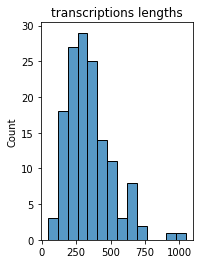

In [18]:


text_word_lengths = [transc_words[i].shape[0] for i in np.arange(len(transc_words))]


plt.figure()
plt.subplot(1,2,1)
plt.title('transcriptions lengths')
sns.histplot(text_word_lengths)


## train test split


In [19]:
#split for the data which is not uncored

X =transcriptions_reddit.text
y = transcriptions_reddit.label
X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size = 0.3 )


In [20]:
#add uncored data to the training set
X_train = pd.concat([X_train,uncored.text])
y_train = pd.concat([y_train , uncored.label])

In [21]:
print('length of X_train',len(X_train), 'length of X_test',len(X_test), 'length of y_train',len(y_train), 'length of y_test',len(y_test))

length of X_train 38362 length of X_test 7653 length of y_train 38362 length of y_test 7653


In [22]:
X_train

9086     hi pleas stick tri cut chase suffer chronic an...
20423    want end afraid death entail also hate idea al...
9945     year two ago gave love ever realli find sens b...
15780                                          asot awesom
19436    diagnos one point anoth life first chronic man...
                               ...                        
20500    yes okay l a  0  the  0   0   0   0   0   0  e...
20501    yes i am not  0  i am a little  0  but okay  0...
20502    yes i am  0   0  i am from  0   0   0   0  and...
20503    yes i am  0  thank you  0   0  yes i  0  to l ...
20504    yes  0   0  i have a  0  to  0   0  i found ou...
Name: text, Length: 38362, dtype: object

## word tokenize and word 2 vec

In [23]:


X_train = [word_tokenize(str(_)) for _ in X_train]
X_test = [word_tokenize(str(_)) for _ in X_test]



In [24]:


# This line trains an entire embedding for the words in your train set
word2vec = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=5)

In [25]:
word2vec.wv.index_to_key

['0',
 'i',
 'to',
 'and',
 'not',
 'the',
 'my',
 'a',
 'am',
 'it',
 'is',
 'of',
 'have',
 'me',
 'do',
 'that',
 'in',
 'like',
 'but',
 'just',
 'for',
 'can',
 'so',
 'want',
 'this',
 'was',
 'with',
 'know',
 'be',
 'you',
 'get',
 'on',
 'even',
 'all',
 'would',
 'or',
 'myself',
 'about',
 'because',
 'go',
 'what',
 'at',
 'if',
 'will',
 'no',
 'they',
 'one',
 'think',
 'out',
 'feel',
 'are',
 'been',
 'up',
 'as',
 'when',
 'how',
 'now',
 'never',
 'much',
 'she',
 'really',
 'had',
 'help',
 'could',
 'make',
 'going',
 'there',
 'from',
 'he',
 'her',
 'them',
 'its',
 'anymore',
 'better',
 'take',
 'did',
 'more',
 'back',
 'still',
 'way',
 'being',
 'got',
 'see',
 'only',
 'depress',
 'need',
 'we',
 'an',
 'who',
 'life',
 'end',
 'why',
 'some',
 'anything',
 'say',
 'time',
 'any',
 'everything',
 'then',
 'right',
 'always',
 'ever',
 'nothing',
 'um',
 'last',
 'too',
 'does',
 'something',
 'other',
 'keep',
 'by',
 'also',
 'every',
 'here',
 'thing',
 's

# data embedding

## embed data

In [26]:
def embed_sentence(word2vec, sentence):
    # $CHALLENGIFY_BEGIN
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [27]:
def embedding(word2vec, sentences):
    # $CHALLENGIFY_BEGIN
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
    # $CHALLENGIFY_END
    
X_train = embedding(word2vec, X_train)
X_test = embedding(word2vec, X_test)

## pad data

In [13]:
'''X_train_pad = pad_sequences(X_train, dtype='float', padding='post')
X_test_pad = pad_sequences(X_test, dtype='float', padding='post')'''

"X_train_pad = pad_sequences(X_train, dtype='float', padding='post')\nX_test_pad = pad_sequences(X_test, dtype='float', padding='post')"

In [73]:
print('number of train texts: ' ,len(X_train))
X_train[3].shape[0]

number of train texts:  38362


6

In [74]:
text_word_lengths = [X_train[i].shape[0] for i in np.arange(len(X_train))]
text_word_lengths_test = [X_test[i].shape[0] for i in np.arange(len(X_test))]

<AxesSubplot:title={'center':'test data lengths'}, ylabel='Count'>

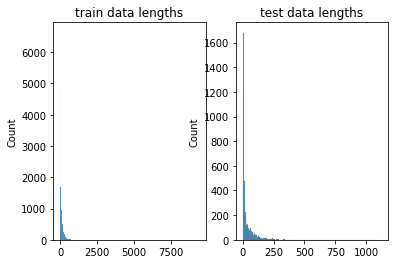

In [75]:
plt.figure()
plt.subplot(1,2,1)
plt.title('train data lengths')
sns.histplot(text_word_lengths)
plt.subplot(1,2,2)
plt.title('test data lengths')
sns.histplot(text_word_lengths_test)

In [ ]:
#cortamos en 1000 words

X_train_pad = pad_sequences(X_train, dtype='float', padding='post', maxlen= 250,truncating= 'pre')
X_test_pad = pad_sequences(X_test, dtype='float', padding='post', maxlen = 250 , truncating = 'pre')


# the model

## baseline score

In [50]:
from sklearn.metrics import accuracy_score

unique, counts = np.unique(y_train, return_counts=True)
counts = dict(zip(unique, counts))
print('Number of labels in train set', counts)

y_pred = 0 if counts[0] > counts[1] else 1

print('Baseline accuracy: ', accuracy_score(y_test, [y_pred]*len(y_test)))

Number of labels in train set {0.0: 31, 1.0: 26}
Baseline accuracy:  0.36


## first neural network

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(100, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(100, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(50, activation='tanh'))

    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(25, activation='tanh'))

    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='tanh'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC','Precision','Recall'])
    
    return model

model = init_model()

2022-03-16 11:59:39.484194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 11:59:39.484246: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 11:59:39.484268: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-QMHRL2V): /proc/driver/nvidia/version does not exist
2022-03-16 11:59:39.484658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [59]:
y_train

Unnamed: 0
326.0    0.0
347.0    1.0
449.0    0.0
356.0    1.0
463.0    0.0
310.0    0.0
313.0    0.0
464.0    0.0
377.0    1.0
345.0    1.0
418.0    1.0
390.0    0.0
369.0    0.0
457.0    0.0
468.0    0.0
372.0    1.0
426.0    1.0
312.0    0.0
363.0    0.0
379.0    0.0
417.0    0.0
439.0    0.0
451.0    0.0
368.0    0.0
316.0    0.0
318.0    0.0
352.0    1.0
319.0    1.0
346.0    1.0
376.0    1.0
388.0    1.0
341.0    0.0
422.0    1.0
320.0    1.0
443.0    0.0
416.0    0.0
386.0    1.0
367.0    1.0
392.0    0.0
402.0    1.0
448.0    1.0
412.0    1.0
335.0    1.0
485.0    0.0
441.0    1.0
303.0    0.0
440.0    1.0
371.0    0.0
315.0    0.0
395.0    0.0
355.0    1.0
382.0    0.0
413.0    1.0
350.0    1.0
325.0    1.0
458.0    0.0
391.0    0.0
Name: PHQ8_Binary, dtype: float64

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=50, restore_best_weights=True)

history_fit = model.fit(X_train_pad, y_train.values, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose = 1
         )

Epoch 1/100
2/2 [==============================] - 25s 7s/step - loss: 0.7931 - accuracy: 0.4615 - auc: 0.4035 - precision: 0.4000 - recall: 0.6250 - val_loss: 0.6970 - val_accuracy: 0.4444 - val_auc: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 5s 2s/step - loss: 0.6808 - accuracy: 0.5897 - auc: 0.5883 - precision: 0.5000 - recall: 0.5625 - val_loss: 0.7204 - val_accuracy: 0.4444 - val_auc: 0.5500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 6s 3s/step - loss: 0.7621 - accuracy: 0.4615 - auc: 0.4307 - precision: 0.3529 - recall: 0.3750 - val_loss: 0.6876 - val_accuracy: 0.5556 - val_auc: 0.5375 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 4/100
2/2 [==============================] - 5s 3s/step - loss: 0.6822 - accuracy: 0.4872 - auc: 0.5448 - precision: 0.4091 - recall: 0.5625 - val_loss: 0.6948 - val_accuracy: 0.4444 - val_auc: 0.6500 - val_precision: 0.0

In [21]:
'''import joblib
joblib.dump(model, 'rnn_reddit.sav')'''

2022-03-10 19:24:49.067663: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://849c2deb-a514-4095-ab82-9e0451bf807c/assets


INFO:tensorflow:Assets written to: ram://849c2deb-a514-4095-ab82-9e0451bf807c/assets


['rnn_reddit.sav']

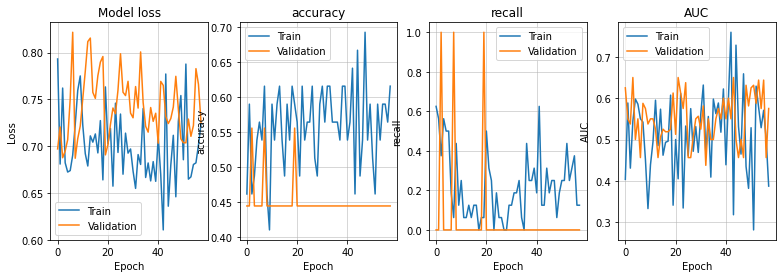

In [70]:
def plot_loss_mae(history):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim(ymin=0, ymax=200)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('Epoch')
    #ax2.set_ylim(ymin=0, ymax=20)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    
    
    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('recall')
    ax3.set_ylabel('recall')
    ax3.set_xlabel('Epoch')
    #ax3.set_ylim(ymin=0, ymax=20)
    ax3.legend(['Train', 'Validation'], loc='best')
    ax3.grid(axis="x",linewidth=0.5)
    ax3.grid(axis="y",linewidth=0.5)
    
    ax4.plot(history.history['auc'])
    ax4.plot(history.history['val_auc'])
    ax4.set_title('AUC')
    ax4.set_ylabel('AUC')
    ax4.set_xlabel('Epoch')
    #ax4.set_ylim(ymin=0, ymax=20)
    ax4.legend(['Train', 'Validation'], loc='best')
    ax4.grid(axis="x",linewidth=0.5)
    ax4.grid(axis="y",linewidth=0.5)
    
    plt.show()

plot_loss_mae(history_fit)

In [72]:
evaluation = model.evaluate(X_test_pad , y_test.values , verbose = 1 , return_dict=True)

1/1 [==============================] - 1s 531ms/step - loss: 0.6794 - accuracy: 0.6400 - auc: 0.2569 - precision: 0.6400 - recall: 1.0000


In [73]:
evaluation

{'loss': 0.6794221997261047,
 'accuracy': 0.6399999856948853,
 'auc': 0.2569444477558136,
 'precision': 0.6399999856948853,
 'recall': 1.0}